In [1]:
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
f=h5py.File('/inputdata/cms-open-data-ml/big_train_test_data.h5','r')

In [3]:
for n in f.keys():
    print f[n]

<HDF5 dataset "X_0_test": shape (148244, 30, 30, 1), type "<f8">
<HDF5 dataset "X_0_train": shape (148244, 30, 30, 1), type "<f8">
<HDF5 dataset "X_1_test": shape (148244,), type "<f8">
<HDF5 dataset "X_1_train": shape (148244,), type "<f8">
<HDF5 dataset "X_2_test": shape (148244,), type "<f8">
<HDF5 dataset "X_2_train": shape (148244,), type "<f8">
<HDF5 dataset "encoded_Y_test": shape (148244,), type "<f8">
<HDF5 dataset "encoded_Y_train": shape (148244,), type "<f8">


In [4]:
encoded_Y_train = f['encoded_Y_train'].value
encoded_Y_test = f['encoded_Y_test'].value
X_train = [f['X_%d_train'%j].value for j in range(0,3)]
X_test = [f['X_%d_test'%j].value for j in range(0,3)]

In [5]:
# change pT range from 0 - 100, since we read in pthat 120-470
np.clip(X_train[0],0,700,out=X_train[0])
np.clip(X_test[0],0,700,out=X_test[0])
#scale
scaler = StandardScaler()
X_train[1] = scaler.fit_transform(X_train[1].reshape(-1,1))
X_test[1] = scaler.transform(X_test[1].reshape(-1,1))
#X_train[2] /= np.max(np.abs(2.5),axis=0)
#X_test[2] /= np.max(np.abs(2.5),axis=0)
X_train[2] /= 2.5
X_test[2] /= 2.5

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

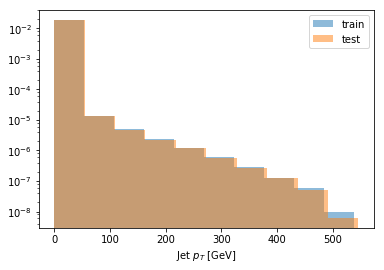

In [7]:
plt.hist(np.ravel(X_train[0]), label='train', alpha=0.5, normed=True)
plt.hist(np.ravel(X_test[0]), label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel(r'Jet $p_{T}$ [GeV]')
plt.show()

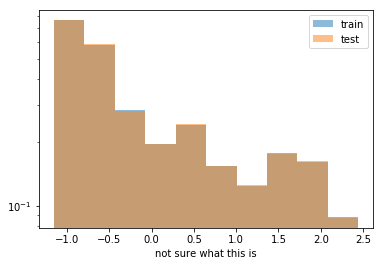

In [8]:
plt.hist(np.ravel(X_train[1]), label='train', alpha=0.5, normed=True)
plt.hist(np.ravel(X_test[1]), label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel('not sure what this is')
plt.show()

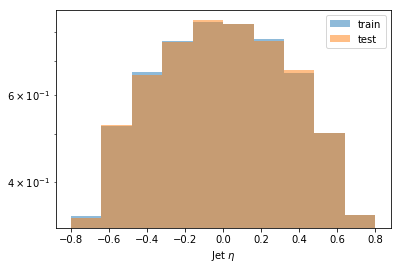

In [9]:
plt.hist(np.ravel(X_train[2]), label='train', alpha=0.5, normed=True)
plt.hist(np.ravel(X_test[2]), label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel(r'Jet $\eta$')
plt.show()

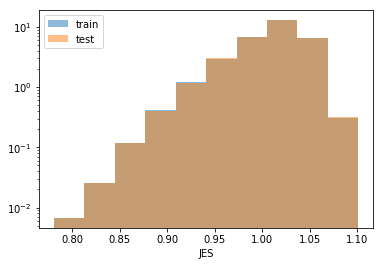

In [10]:
plt.hist(encoded_Y_train, label='train', alpha=0.5, normed=True)
plt.hist(encoded_Y_test, label='test', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel('JES')
plt.show()

In [18]:
import os, getpass
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES']='2'

from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model
from keras.layers import Merge, merge

input_layer = Input(shape=(30,30,1))
layer = Convolution2D(20, 11,11, border_mode='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(15, 9, 9, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, 7, 7, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Convolution2D(8, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(5, 4, 4, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(4, 3, 3, border_mode='same')(layer)
layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Flatten()(layer)
# additional features input
jet_pt_ak7_input = Input(shape=(1,), name='jet_pt_ak7_input')
jet_eta_ak7_input = Input(shape=(1,), name='jet_eta_ak7_input')
layer = merge([layer, jet_pt_ak7_input, jet_eta_ak7_input], mode='concat')
#layer = Dropout(0.20)(layer)
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
#other activation option 'sigmoid' better for bounded problem
output_layer = Dense(1, activation='linear', name='main_output')(layer)
model = Model(input=[input_layer,jet_pt_ak7_input,jet_eta_ak7_input], output=output_layer)
#model = Model(input=input_layer, output=output_layer)
#model.compile(optimizer='adam', loss='kullback_leibler_divergence', metrics=['accuracy','precision','mse','msle'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy','precision','mse','msle'])

In [20]:
'''
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras_diagram import ascii
print(ascii(model))

'''

ImportError: No module named keras_diagram

In [21]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [22]:
bs=10

In [ ]:
model.fit(X_train, encoded_Y_train, 
         validation_data=(X_test, encoded_Y_test),
         nb_epoch=100, batch_size=bs, verbose=1, callbacks=[early_stopping])

Train on 148244 samples, validate on 148244 samples
Epoch 1/100
148244/148244 [==============================] - 132s - loss: 0.0060 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 0.0060 - mean_squared_logarithmic_error: 0.0016 - val_loss: 0.0010 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 0.0010 - val_mean_squared_logarithmic_error: 2.6439e-04
Epoch 2/100
148244/148244 [==============================] - 130s - loss: 9.9122e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 9.9122e-04 - mean_squared_logarithmic_error: 2.5107e-04 - val_loss: 8.3148e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 8.3148e-04 - val_mean_squared_logarithmic_error: 2.1033e-04
Epoch 3/100
148244/148244 [==============================] - 130s - loss: 8.2653e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 8.2653e-04 - mean_squared_logarithmic_error: 2.0928e-04 - val_loss: 7.4395e-04 - val_acc: 0.0000e+00 - val_prec

In [15]:
p_train = model.predict(X_train)
p_test = model.predict(X_test)

In [16]:
def plot_JEC( xyls ):
    plt.figure(figsize=(6,6))
    plt.grid()
    for X,Y,L in xyls:
        plt.scatter( X,Y, label=L, alpha=0.5 , marker='.')
    plt.xlim((0.8,1.2))
    plt.ylim((0.8,1.2))
    plt.hlines(1., 0.8,1.2)
    plt.vlines(1., 0.8,1.2)
    plt.xlabel( 'True JEC')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

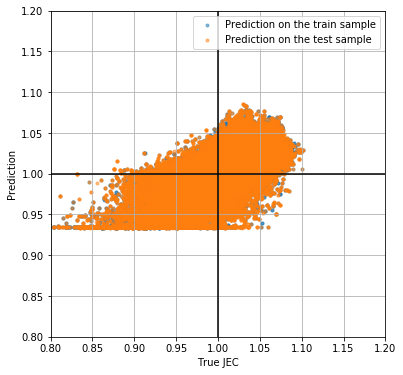

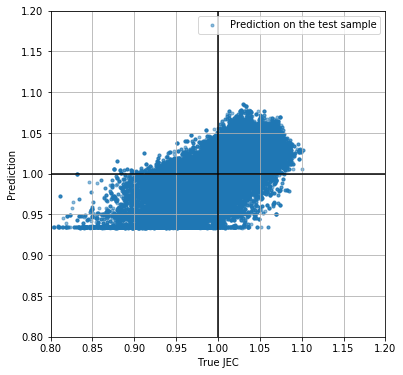

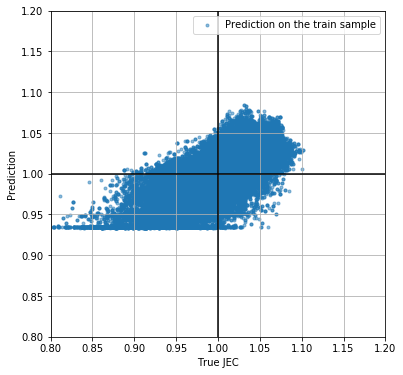

In [17]:
plot_JEC([
    (encoded_Y_train, p_train, 'Prediction on the train sample'),
    (encoded_Y_test, p_test, 'Prediction on the test sample')
])
plot_JEC([(encoded_Y_test, p_test, 'Prediction on the test sample')])
plot_JEC([(encoded_Y_train, p_train, 'Prediction on the train sample')])